# Models and Evaluation

In [110]:
import pandas as pd
import numpy as np
from IPython.display import display

data = pd.read_csv('data_processed/data.csv')
data

,loan_id,account_id,amount,duration,payments,status,client_id,district_id,gender,disp_id,has_disponent,age_on_loan_request,account_frequency,card_type,last_balance,monthly_diff,age_on_loan_request_disc
0,5314,1787,96396,12,8033,-1,2166,30,Female,2166,False,46,weekly issuance,unkown,20100.0,5025,40-49
1,5316,1801,165960,36,4610,1,2181,46,Male,2181,False,25,monthly issuance,unkown,52208.9,-6096,21-29
2,6863,9188,127080,60,2118,1,11314,45,Male,11006,False,57,monthly issuance,unkown,20272.8,-10726,50-59
3,5325,1843,105804,36,2939,1,2235,14,Female,2235,False,53,monthly issuance,unkown,34292.7,-13591,50-59
4,7240,11013,274740,60,4579,1,13539,63,Male,13231,False,15,weekly issuance,unkown,41142.9,-35661,0-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,9030,155616,48,3242,1,11121,72,Female,10813,False,26,monthly issuance,unkown,60694.1,3950,21-29
324,5625,3189,222180,60,3703,-1,3855,29,Male,3855,False,58,monthly issuance,unkown,59578.8,2556,50-59
325,6805,8972,45024,48,938,1,11050,70,Female,10742,False,40,monthly issuance,unkown,38384.3,5335,40-49
326,7233,10963,115812,36,3217,1,13480,16,Male,13172,False,44,monthly issuance,unkown,41878.1,-17,40-49


In [111]:
data.drop(['loan_id', 'account_id', 'client_id', 'district_id', 'disp_id'], axis=1, inplace=True)

def get_features(df):
    return df.drop('status', axis=1).values
def get_target(df):
    return df['status'].values

display(data.info())


results = {}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   amount                    328 non-null    int64  
 1   duration                  328 non-null    int64  
 2   payments                  328 non-null    int64  
 3   status                    328 non-null    int64  
 4   gender                    328 non-null    object 
 5   has_disponent             328 non-null    bool   
 6   age_on_loan_request       328 non-null    int64  
 7   account_frequency         328 non-null    object 
 8   card_type                 328 non-null    object 
 9   last_balance              328 non-null    float64
 10  monthly_diff              328 non-null    int64  
 11  age_on_loan_request_disc  328 non-null    object 
dtypes: bool(1), float64(1), int64(6), object(4)
memory usage: 28.6+ KB


None

In [112]:
from sklearn.model_selection import train_test_split
def split_data(features, target, test_size=0.2, random_state=1):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [113]:
from sklearn.preprocessing import LabelEncoder

def add_model(name, model):
    le = LabelEncoder()
    df = data.copy()
    if (name == 'dtc'):
        df.drop(['age_on_loan_request_disc'], inplace=True, axis=1)
    else:
        df.drop(['age_on_loan_request'], inplace=True, axis=1)
        df['age_on_loan_request_disc'] = le.fit_transform(df['age_on_loan_request_disc'])
    df['account_frequency'] = le.fit_transform(df['account_frequency'])
    df['card_type'] = le.fit_transform(df['card_type'])
    df['gender'] = le.fit_transform(df['gender'])

    X_train, X_test, y_train, y_test = split_data(get_features(df), get_target(df))
    model.fit(X_train, y_train)
    results[name] = {'model': model, 
                    'X_train': X_train, 
                    'X_test': X_test, 
                    'y_train': y_train, 
                    'y_test': y_test}

In [114]:
from sklearn.tree import DecisionTreeClassifier
add_model('dtc',
    DecisionTreeClassifier()
)

In [115]:
from sklearn.ensemble import RandomForestClassifier
add_model('rf',
    RandomForestClassifier()
)

In [116]:
from sklearn.svm import SVC
add_model('svc',
    SVC(probability=True)
)

In [117]:
def predict(name):
    result = results[name]
    pred = result['model'].predict(result['X_test'])
    result['pred'] = pred

predict('dtc')
predict('rf')
predict('svc')

In [118]:
def predict_proba(name):
    result = results[name]
    proba = result['model'].predict_proba(result['X_test'])
    result['pred_prob'] = proba

predict_proba('dtc')
predict_proba('rf')
predict_proba('svc')


## Evaluation

In [119]:
def recall(cm, i):
    return cm[i][i]/sum(cm[i])

def precision(cm, i):
    cmt = np.copy(cm).transpose()
    return cmt[i][i]/sum(cmt[i])

def f_measure(cm, i):
    p = precision(cm, i)*100
    r = recall(cm, i)*100
    return 2 * (p * r) / (p + r)

In [120]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def conf_matrix(y_test, y_pred):
    cm =  confusion_matrix(y_test, y_pred)
    '''
    print("TP:", cm[1][1])
    print("TN:", cm[0][0])
    print("FP:", cm[0][1])
    print("FN:", cm[1][0])
    '''
    ConfusionMatrixDisplay(cm, display_labels=['True', 'False']).plot()

In [121]:
def score(name):
    result = results[name]
    result['score'] = result['model'].score(result['X_test'], result['y_test'])
    print(name.upper()+":", result['score'])

score('dtc')
score('rf')
score('svc')

DTC: 0.8787878787878788
RF: 0.8939393939393939
SVC: 0.8939393939393939


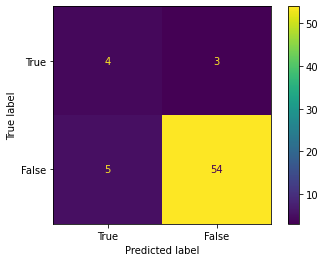

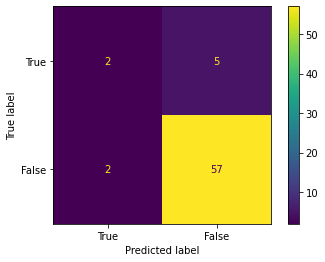

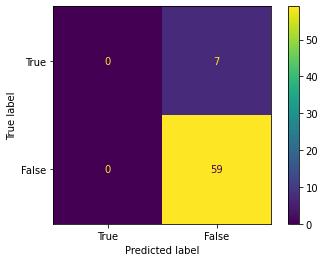

In [122]:
prob = 0.50

conf_matrix(results['dtc']['y_test'], np.where(results['dtc']['pred_prob'][:,-1] > prob, 1, -1))
conf_matrix(results['rf']['y_test'], np.where(results['rf']['pred_prob'][:,-1] > prob, 1, -1))
conf_matrix(results['svc']['y_test'], np.where(results['svc']['pred_prob'][:,-1] > prob, 1, -1))

0.7433414043583535
0.8474576271186441
0.5302663438256658


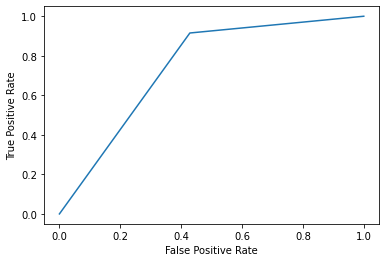

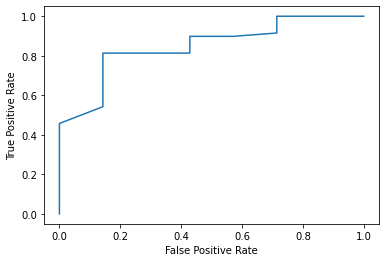

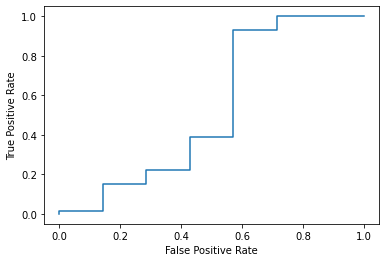

In [123]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc

def roc_and_auc(name):
    result = results[name]
    fpr, tpr, _ = roc_curve(result['y_test'], result['pred_prob'][:,-1], pos_label=result['model'].classes_[1])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    print(auc(fpr, tpr))

roc_and_auc('dtc')
roc_and_auc('rf')
roc_and_auc('svc')